# 12.1 Polynomial Regression

Let’s consider a hypothetical situation in which we want to predict an exam score  (0–100%) from the number of hours studied per day. A purely linear model might miss an important “sweet spot,” since studying too many hours can lead to fatigue or burnout. By adding a quadratic term, we can model a peak in performance:

To demostrate this, lets simulate a dataset with two variables `study_time` and `grade`:

In [1]:
import numpy as np
import pandas as pd

# Simulate the data
np.random.seed(69)
study_time = np.linspace(1, 10, 500)
h = 6
k = 80
grades = -(k / (h**2)) * (study_time - h)**2 + k + np.random.normal(0, 8, study_time.shape)
grades = np.clip(grades, 0, 100) # ensure we only have grades between 0 and 100

# Create a DataFrame
df = pd.DataFrame({"study_time": study_time, "grades": grades})
print(df.head())

   study_time     grades
0    1.000000  31.768501
1    1.018036  20.016187
2    1.036072  34.541517
3    1.054108  20.829142
4    1.072144  13.256199


We can then plot the two variables to check if everything looks as expected:

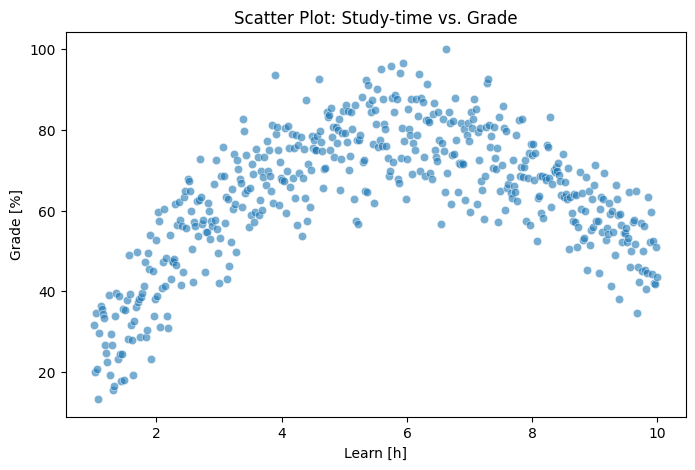

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=df, x="study_time", y="grades", alpha=0.6, ax=ax)
ax.set(xlabel="Learn [h]",
       ylabel="Grade [%]",
       title="Scatter Plot: Study-time vs. Grade");

That seems to work! We can clearly see the non-linear component is present in our data. We will now proceed to first fit a linear and then a polynomial model to this data. For this, we will use the `statsmodels` and `sklearn` packages.


## Fitting polynomial models

To begin with, lets start with a first order polynomial model. You will then see how easy it is to extend this to as many orders as you like :)

### First order polynomial model

To creare a polynomial model, we first need to create polynomial features:

In [3]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

polynomial_features_p1 = PolynomialFeatures(degree=1, include_bias=True)
study_time_p1 = polynomial_features_p1.fit_transform(study_time.reshape(-1, 1))

**What are polynomial features?**  
In a standard linear regression, our model has the form  

$$y = \beta_0 + \beta_1 x $$
 
However, this assumes a linear relationship between $x$ (e.g., study time) and $y$ (e.g., grades). If we suspect a non-linear relationship, we can augment our single feature $x$ with additional powers of $x$ (e.g., $x^2, x^3, \dots$). This creates a polynomial model, for instance:  
 
$$y = \beta_0 + \beta_1 x + \beta_2 x^2 + \cdots + \beta_p x^p$$

**Why do we need to transform $x$ into polynomial features?**  
Ordinary Least Squares (OLS) regression, by itself, fits linear relationships between predictors and the outcome. To enable OLS to fit a polynomial curve, we transform each original predictor into several “polynomial features” (e.g., $x^1, x^2, x^3 \ldots$) and then feed these new features into the linear regression model. Under the hood, the regression is still linear in terms of these transformed features, but effectively it’s fitting a polynomial in terms of the original $x$.

**Using `PolynomialFeatures(degree=1, include_bias=True)`**  
`degree=1` means we want to create polynomial features up to (and including) the first power. `include_bias=True` means a column of all 1’s (the “bias term”) will be added automatically, corresponding to the intercept $\beta_0$.  

For `degree=1`, the transformation looks like:  
   
$$x \quad \rightarrow \quad \begin{bmatrix} 1 \\ x \end{bmatrix}$$

So you end up with two columns: one for the intercept (all 1’s) and one for the original $x$ values.

**Fitting and transforming**  
`fit_transform(study_time.reshape(-1, 1))` does two things:
  
1. It reshapes `study_time` from shape `(n,)` into a 2D array of shape `(n,1)` by using `.reshape(-1, 1)`. This is the expected input for the sklearn library.

2. It applies the transformation to the original data, producing a 2D array of shape `n, 2` (for `degree=1`), where $n$ is the number of data points. The first column of `study_time_p1` is all 1’s (intercept), and the second column is the original study times because `degree=1` is *technically* the same as a standard linear regression. However, if you later decide to use higher degrees, you will get columns for $x^1,x^2, \dots x^n$. That’s when you can capture curved relationships in your model.

With the features created, we can then use the standard `sm.OLS()` approach to create and fit the model:

In [4]:
# Fit the model
model_linear = sm.OLS(grades, study_time_p1) 
model_linear_fit = model_linear.fit()

# Get model predictions and residuals
linear_predictions = model_linear_fit.predict(study_time_p1)
linear_residuals = model_linear_fit.resid

Now we can visualize the model and its residuals:

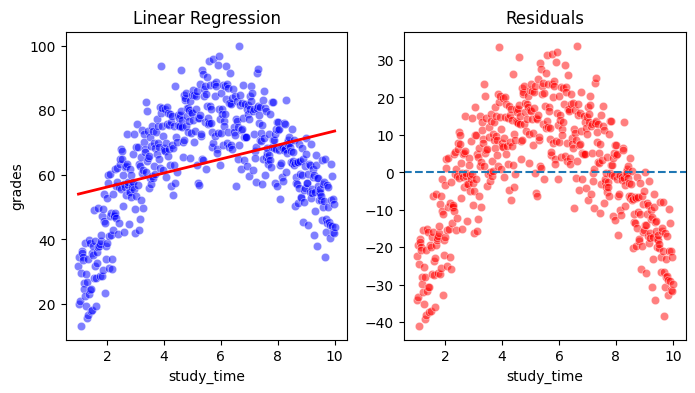

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

sns.scatterplot(data=df, x="study_time", y="grades", color='blue', alpha=0.5, ax=ax[0])
ax[0].plot(study_time, linear_predictions, color='red', linewidth=2)
ax[0].set_title('Linear Regression')

sns.scatterplot(data=df, x="study_time", y=linear_residuals, color='red', alpha=0.5, ax=ax[1])
bottom, top = ax[1].get_ylim()        # Get y-axis lower and upper limits
ax[1].axhline(0, linestyle='--')
ax[1].set_title('Residuals');

From the upper plot one can already see that whilst there being a linear trend present in the data, the model underestimates the complexitiy of the relationship. Looking at the residuals, it becomes clear that once the strong positive linear trend in the data has been removed, the curvilinearity stands out! The residuals are systematically related to the value of $X$: below zero for low and high values of $X$, and above zero for moderate values of $X$. This is the graphical diagnosis for the existence of a non-linear relationship, higher than degree “1”.

### Second order polynomial model

To improve model fit, lets inlcude a second order polynomials. The procedure is the same as before, except we now use `degree=2` for our features:

In [6]:
# Transform study_time
polynomial_features_p2 = PolynomialFeatures(degree=2, include_bias=True)
study_time_p2 = polynomial_features_p2.fit_transform(study_time.reshape(-1, 1))

# Fit the model
model_quadratic = sm.OLS(grades, study_time_p2)
model_quadratic_fit = model_quadratic.fit()

# Get model predictions and residuals
quadratic_predictions = model_quadratic_fit.predict(study_time_p2)
quadratic_residuals = model_quadratic_fit.resid

Lets also plot our new model and its residuals:

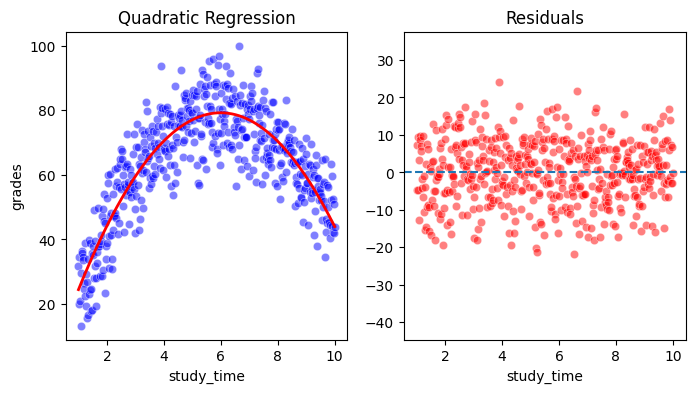

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

sns.scatterplot(data=df, x="study_time", y="grades", color='blue', alpha=0.5, ax=ax[0])
ax[0].plot(study_time, quadratic_predictions, color='red', linewidth=2)
ax[0].set_title('Quadratic Regression')

sns.scatterplot(data=df, x="study_time", y=quadratic_residuals, color='red', alpha=0.5, ax=ax[1])
ax[1].set_ylim(bottom, top)         # Set y-axis lower and upper limits
ax[1].axhline(0, linestyle='--')
ax[1].set_title('Residuals');

We can already see that the model fits the data much better. Also, the residuals are smaller and not dependent on $X$.


## Interpretation

The interpretation of the model results is similar to that for normal linear models, except that we now have estimates for the linear and quadratic terms:

In [8]:
print(model_quadratic_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     744.5
Date:                Wed, 09 Apr 2025   Prob (F-statistic):          3.14e-150
Time:                        08:53:24   Log-Likelihood:                -1771.1
No. Observations:                 500   AIC:                             3548.
Df Residuals:                     497   BIC:                             3561.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2520      1.696      0.149      0.8

**Coefficients**
- **Intercept** (`const`): Close to zero (not significant).
- **Linear term** (`x1`): Positive and highly significant.
- **Quadratic term** (`x2`): Negative and highly significant, indicating an inverted U-shaped relationship.

**Model Fit**
- `R-squared = 0.750`: 75% of the variance in `grade` is explained.
- A negative quadratic term means the model predicts an initial increase in grade as study time increases, followed by a decrease past a certain point.

To further evaluate the model, lets also look at the model fit from the linear model:

In [9]:
print(model_linear_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     64.28
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           7.76e-15
Time:                        08:53:24   Log-Likelihood:                -2087.1
No. Observations:                 500   AIC:                             4178.
Df Residuals:                     498   BIC:                             4187.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.8266      1.647     31.468      0.0

We can observe the following:

- The quadratic model explains much more variance (75% vs. 11.4%) and provides a better fit according to AIC/BIC.
- The negative quadratic term suggests that once study time goes beyond a certain point, additional hours may lead to diminishing or even negative returns on grades (the “inverted U” shape).

Therefore, having a quadratic term improves the model substantially and gives us a more nuanced picture of how study time relates to grades.